<a href="https://colab.research.google.com/github/carlosmirandadurand/Experiments/blob/main/optimization_gurobi/portfolio_selection_optimization_gcl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Selection Optimization
This model is an example of the classic [Markowitz portfolio selection optimization model](https://en.wikipedia.org/wiki/Markowitz_model). We want to find the fraction of the portfolio to invest among a set of stocks that balances risk and return. It is a Quadratic Programming (QP) model with vector and matrix data for returns and risk, respectively. This is best suited to a matrix formulation, so we use the Gurobi Python *matrix* interface. The basic model is fairly simple, so we also solve it parametrically to find the efficient frontier.

**Download the Repository** <br /> 
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip). 


## Model Formulation
### Parameters

We use the [Greek values](https://en.wikipedia.org/wiki/Greeks_\(finance\)) that are traditional in finance:

- $\delta$: n-element vector measuring the change in price for each stock
- $\sigma$: n x n matrix measuring the covariance among stocks

There is one additional parameter when solving the model parametrically:

- r: target return


### Decision Variables
- $x \ge 0$: n-element vector where each element represents the fraction of the porfolio to invest in each stock

### Objective Function
Minimize the total risk, a convex quadratic function:

\begin{equation}
\min x^t \cdot \sigma \cdot x
\end{equation}

### Constraints

Allocate the entire portfolio: the total investments should be 1.0 (100%), where $e$ is a unit vector (all 1's):

\begin{equation}
e \cdot x = 1
\end{equation}


Return: When we solve the model parametrically for different return values $r$, we add a constraint on the target return:

\begin{equation}
\delta \cdot x = r
\end{equation}

## Python Implementation
### Stock data
Use [yfinance](https://pypi.org/project/yfinance/) library to get the latest 2 years of _actual stock data_ from the 20 most profitable US companies, [according to Wikipedia in April 2021](https://en.wikipedia.org/wiki/List_of_largest_companies_in_the_United_States_by_revenue#List_of_companies_by_profit).

In [1]:
%pip install gurobipy yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 3.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting un

In [2]:
import yfinance as yf

stocks = ['BRK-A', 'AAPL', 'MSFT', 'JPM', 'GOOG', 'BAC', 'INTC', 'WFC',
          'C', 'VZ', 'META', 'PFE', 'JNJ', 'WMT', 'XOM',
          'FNMA', 'T', 'UNH', 'CMCSA', 'V' ]

data = yf.download(stocks, period='2y')

[*********************100%***********************]  20 of 20 completed


In [39]:
# Inspect the data from the yfinance package
stocks_columns = {}
for k,v in data.columns:
  stocks_columns[v] = stocks_columns[v] + [k] if v in stocks_columns else [k]

print('Stocks:', ', '.join(stocks_columns.keys()), '\n')
print('MSFT columns:', stocks_columns['MSFT'], '\n')
print('Row indexes:', data.index, '\n')
print('Full stock df:', data.shape)
print('Close prices df:', data.Close.shape, '\n')

data.Close.describe()

Stocks: AAPL, BAC, BRK-A, C, CMCSA, FNMA, GOOG, INTC, JNJ, JPM, META, MSFT, PFE, T, UNH, V, VZ, WFC, WMT, XOM 

MSFT columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] 

Row indexes: DatetimeIndex(['2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12',
               '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19',
               '2021-02-22', '2021-02-23',
               ...
               '2023-01-27', '2023-01-30', '2023-01-31', '2023-02-01',
               '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07',
               '2023-02-08', '2023-02-09'],
              dtype='datetime64[ns]', name='Date', length=505, freq=None) 

Full stock df: (505, 120)
Close prices df: (505, 20) 



,AAPL,BAC,BRK-A,C,CMCSA,FNMA,GOOG,INTC,JNJ,JPM,META,MSFT,PFE,T,UNH,V,VZ,WFC,WMT,XOM
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,148.170772,38.944465,440642.459158,59.803477,46.987346,1.002328,120.442845,45.844069,169.371564,142.110455,244.650258,273.157475,46.453218,19.755599,464.032941,215.532495,50.038168,45.689693,139.861475,78.162336
std,15.359783,4.880937,34805.028898,10.868120,8.982493,0.579169,17.776332,11.668356,6.381418,18.334921,87.683736,31.051091,6.009152,1.973179,58.569614,14.439292,6.718559,4.609945,7.994724,19.715027
min,116.360001,29.770000,361290.000000,40.450001,28.680000,0.350000,83.489998,25.040001,153.070007,101.959999,88.910004,214.250000,33.490002,14.630000,324.579987,177.649994,35.349998,32.720001,118.290001,49.840000
25%,136.009995,34.869999,418500.000000,49.779999,39.259998,0.570000,104.794502,35.779999,164.270004,127.239998,163.740005,247.110001,42.090000,18.320000,412.500000,206.520004,44.779999,42.880001,135.130005,60.410000
50%,147.539993,38.680000,433124.000000,60.650002,48.110001,0.820000,118.779999,48.810001,168.880005,146.610001,232.000000,267.660004,47.430000,19.456194,478.140015,214.850006,52.400002,45.680000,140.720001,77.360001
75%,159.220001,42.549999,467650.000000,70.080002,55.080002,1.170000,137.004501,54.470001,174.470001,157.449997,330.250000,296.029999,51.130001,21.190001,513.809998,226.440002,55.299999,48.130001,144.779999,94.010002
max,182.009995,49.380001,539180.000000,79.860001,61.750000,2.440000,150.709000,68.260002,186.009995,171.779999,382.179993,343.109985,61.250000,24.645016,555.150024,250.929993,59.520000,59.060001,159.869995,117.760002


### Compute Greeks
Using the downloaded stock data, find the delta (return), sigma (covariance) and standard deviation values for stock prices:

In [31]:
import numpy as np

closes = np.transpose(np.array(data.Close)) # matrix of daily closing prices
absdiff = np.diff(closes)                   # change in closing price each day
reldiff = np.divide(absdiff, closes[:,:-1]) # relative change in daily closing price
delta = np.mean(reldiff, axis=1)            # mean price change
sigma = np.cov(reldiff)                     # covariance (standard deviations)
std = np.std(reldiff, axis=1)               # standard deviation

In [33]:
# Inspect the data
closes.shape

(20, 505)

## Minimize risk by solving QP model

In [40]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
m = gp.Model('portfolio')

# Add matrix variable for the stocks
x = m.addMVar(len(stocks))

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')

# Verify model formulation
m.write('portfolio_selection_optimization.lp')

# Optimize model to find the minimum risk portfolio
m.optimize()

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0xe508a6ca
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 4e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 20 columns, 20 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 1.900e+02
 Factor NZ  : 2.100e+02
 Factor Ops : 2.870e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl 

## Display minimum risk portfolio using Pandas

In [41]:
import pandas as pd
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=stocks + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
BRK-A,0.000004
AAPL,0.000004
MSFT,0.000702
JPM,0.000020
GOOG,0.016560
BAC,0.034309
INTC,0.000039
WFC,0.000005
C,0.421950
VZ,0.021991


## Compute the efficient frontier
Solve the QP parametrically to find the lowest risk portfolio for different expected returns.

In [42]:
# Create an expression representing the expected return for the portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x41327325
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-06, 4e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.95099586e+05 -1.95099586e+05  1.10e+04 5.95e-03  1.0

## Plot results
Use the matplot library to plot the optimized solutions, along with the individual stocks:

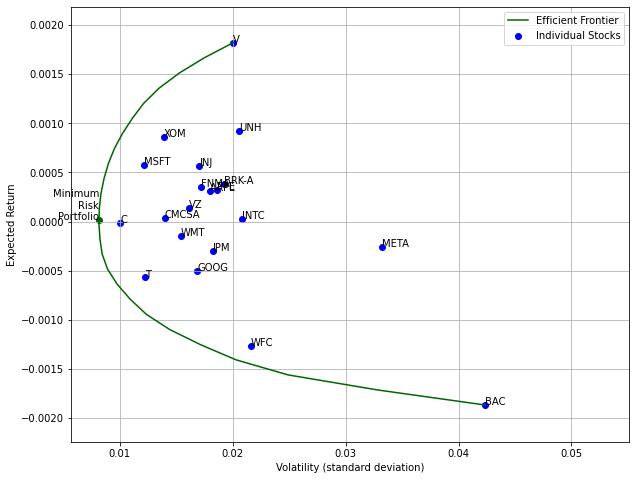

In [43]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()